In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


## Load your infection data (Currently the MOH infection data for year 2020 is loaded)

In [2]:
Data = np.zeros([34,365])
# os.chdir()
# current_directory = os.getcwd()
# directory_path = os.path.join('./PHU_data',current_directory)
PHU_path = './../../PHU_data'
files = os.listdir(PHU_path)

for ii in range(0,34):
  if ii < 9:
    target_name_part = "0"+str(ii+1)+"-"
  else:
    target_name_part = str(ii+1)+"-"
  for file in files:
      if target_name_part in file:
          target_file = file
          break
  else:
      raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

  filepath = os.path.join(PHU_path,target_file)
  Data[ii,:] = np.genfromtxt(filepath, delimiter=',')

population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')

## Manually Tuned PHUs

### Below code contains the manually tuned PHUs with a sum of sigmoid model of infection rate. This model contains several amplitude parameters of the sigmoid and temporal parameters which dictattes the activation of sigmoid. 

### Manual tuning is done to get an initial estimate of the amplitude parameters and the location of each sigmoid.

### 1. Plot the infection data to find out the total number of change in slopes 
### 2. Add a sigmoid to each of these locations where a change is slope is detected.
### 3. Manually change the amplitude parameters of the model to get a reasonably good fit of the infection data
### 4. If necessary include additional sigmoids

### Note :  Use a positive value of amplitude for increasing infection and negative value for decreasing infection. Bear in mind that there is a time lag between which the sigmoid gets activated and the affect of this sigmoid gets reflected in the infection.

# City of Toronto

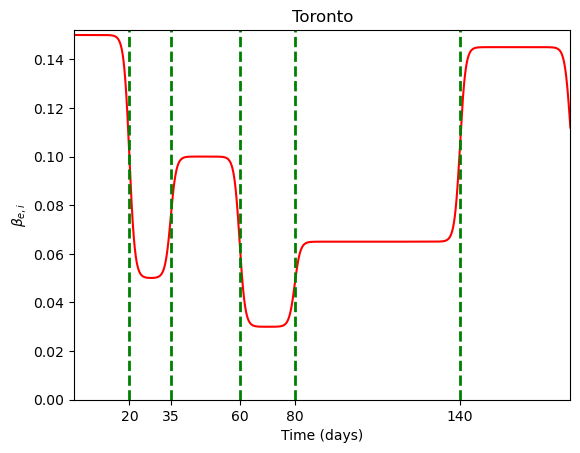

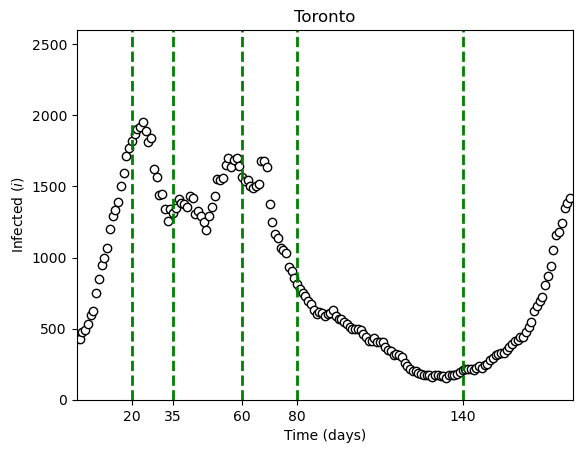

In [10]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

tdata = np.arange(0,365)


Ndays = 200
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))

#### CHANGE HERE ACCORDING TO PHU NUMBER ####
I0 = Data[29,0]/population_by_phu[29,1]
########################################## ####

D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]

## beta = 0.833 gives R0=1

a0 =   0.15
a1 =  -0.1
t1 =  20
a2 =   0.05
t2 =  35
a3 =   -0.07
t3 = 60
a4 =  0.035
t4 = 80
a5 =  0.08
t5 = 140
a6 =  -0.065
t6 = 180
a7 =  0.025
t7 = 190
a8 =  -0.015
t8 = 230

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist)))  + a6/(1 + np.exp((t6-tlist))) + a7/(1 + np.exp((t7-tlist))) + a8/(1 + np.exp((t8-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
# plt.grid(True)
# ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.ylim([0,0.152])
x_positions = [20,35,60,80,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--',linewidth=2)  # Adjust ymin and ymax as needed

plt.xticks(x_positions)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,180])
plt.title("Toronto")
plt.savefig('./figs/beta_toronto.pdf',  bbox_inches='tight')
# plt.ylim([0,0.25])


#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####

plt.figure(2)
# plt.plot(tlist,Ytrue[2,:]*population_by_phu[29,1],'k.', linewidth=0.1, label=r'Generating model')
plt.scatter(tdata[:180],Data[29,:180],color='w',edgecolors='k',zorder=1,alpha=1,label='Data')

plt.ylim([0,2600])
x_positions = [20,35,60,80,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--', linewidth=2)  # Adjust ymin and ymax as needed

plt.xticks(x_positions)
# plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,180])
plt.title("Toronto")
# plt.savefig('./figs/manual_tuned_phu_toronto.pdf',  bbox_inches='tight')
plt.savefig('./figs/Data_phu_toronto.pdf',  bbox_inches='tight')
# plt.ylim([0,0.0005])


## Durham Region

696992.0


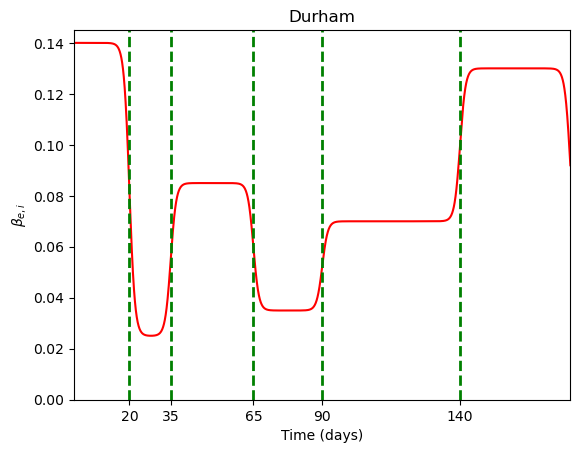

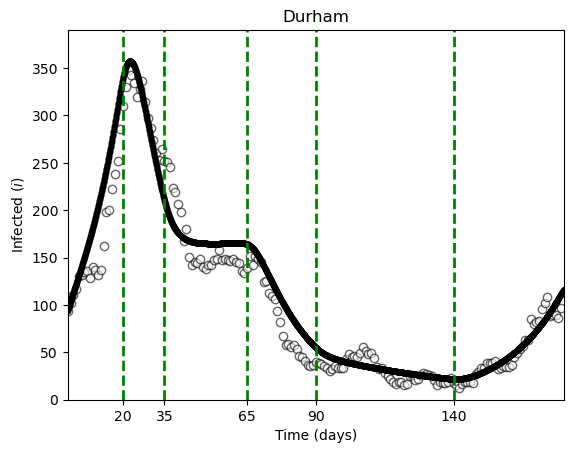

In [12]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

tdata = np.arange(0,365)

Ndays = 274
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750


Ytrue = np.zeros((5,tgrd))
#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####
I0 = Data[3,0]/population_by_phu[3,1]
D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

print(population_by_phu[3,1])

Ytrue[:,0] = [S0,I0,I0,R0,D0]
gamma = 1/12


a0 =   0.14
a1 =  -0.115
t1 =  20
a2 =   0.06
t2 =  35
a3 =   -0.05
t3 = 65
a4 =  0.035
t4 = 90
a5 =  0.06
t5 = 140
a6 =  -0.075
t6 = 180
a7 =  0.06
t7 = 190
a8 =  -0.025
t8 = 250

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist)))  + a6/(1 + np.exp((t6-tlist)))  + a7/(1 + np.exp((t7-tlist)))+ a8/(1 + np.exp((t8-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
# plt.grid(True)
# ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='best')
plt.ylim([0,0.145])
x_positions = [20,35,65,90,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--',linewidth=2)  # Adjust ymin and ymax as needed
plt.xticks(x_positions)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,180])
plt.title("Durham")
plt.savefig('./figs/beta_durham.pdf',  bbox_inches='tight')
# plt.ylim([0,0.25])


#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####
plt.figure(2)
plt.plot(tlist,Ytrue[2,:] * population_by_phu[3,1],'k.', linewidth=3, label=r'Generating model')
plt.scatter(tdata[:180],Data[3,:180],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')

plt.ylim([0,390])
x_positions = [20,35,65,90,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--', linewidth=2)  # Adjust ymin and ymax as needed
plt.xticks(x_positions)
# plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,180])
plt.title("Durham")
# plt.savefig('./figs/Data_phu_durham.pdf',  bbox_inches='tight')
plt.savefig('./figs/manual_tuned_phu_durham.pdf',  bbox_inches='tight')



## Peel Region

In [ ]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

Ndays = 274
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))
#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####
I0 = Data[21,0]/population_by_phu[21,1]
D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]
beta = 0.165
gamma = 1/12

## beta = 0.833 gives R0=1


a0 =   0.15
a1 =  -0.1
t1 =  20
a2 =   0.05
t2 =  35
a3 =   -0.07
t3 = 60
a4 =  0.035
t4 = 80
a5 =  0.08
t5 = 140
a6 =  -0.09
t6 = 180
a7 =  0.065
t7 = 190
a8 =  -0.035
t8 = 235

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist)))  + a6/(1 + np.exp((t6-tlist))) + a7/(1 + np.exp((t7-tlist))) + a8/(1 + np.exp((t8-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
plt.grid(True)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,Ndays])
plt.title("Peel")
plt.savefig('./figs/beta_peel.pdf',  bbox_inches='tight')


#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####
plt.figure(2)
plt.plot(tlist,Ytrue[2,:],'k.', linewidth=3, label=r'Generating model')
plt.scatter(tdata[:274],Data[21,:274]/population_by_phu[21,1],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,Ndays])
plt.title("Peel")
plt.savefig('./figs/manual_tuned_phu_peel.pdf',  bbox_inches='tight')
# plt.ylim([0,0.0005])


## York Region

In [ ]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

Ndays = 274
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))
I0 = Data[33,0]/population_by_phu[33,1]
D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]
beta = 0.165
gamma = 1/12

## beta = 0.833 gives R0=1


a0 =   0.12
a1 =  -0.1
t1 =  20
a2 =   0.08
t2 =  35
a3 =   -0.04
t3 = 50
a4 =  0.07
t4 = 130
a5 = -0.04
t5 = 200
a6 =  0
t6 = 180
a7 =  0
t7 = 230

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist)))  + a6/(1 + np.exp((t6-tlist)))  + a7/(1 + np.exp((t7-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
plt.grid(True)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,Ndays])
plt.title("York")
plt.savefig('./figs/beta_york.pdf',  bbox_inches='tight')



plt.figure(2)
plt.plot(tlist,Ytrue[2,:],'k.', linewidth=3, label=r'Generating model')
plt.scatter(tdata[:274],Data[33,:274]/population_by_phu[33,1],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,Ndays])
plt.title("York")
plt.savefig('./figs/manual_tuned_phu_york.pdf',  bbox_inches='tight')



## Ottawa Region

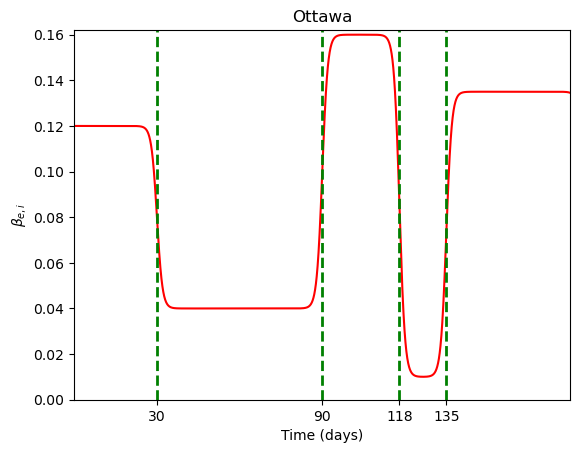

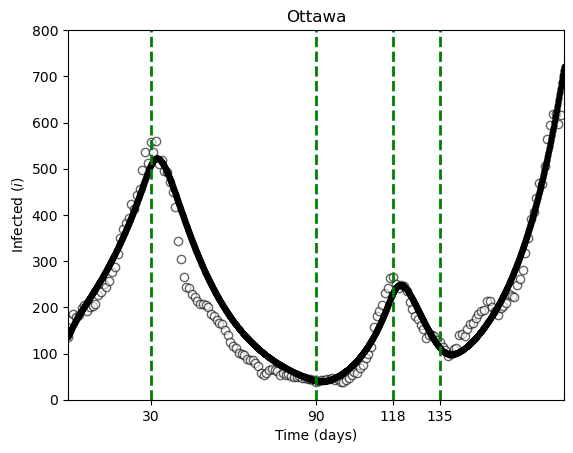

In [15]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

Ndays = 274
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))
I0 = Data[19,0]/population_by_phu[19,1]
D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]
beta = 0.165
gamma = 1/12

## beta = 0.833 gives R0=1


a0 =   0.12
a1 =  -0.08
t1 =  30
a2 =   0.12
t2 =  90
a3 =   -0.15
t3 = 118
a4 =  0.125
t4 = 135
a5 =  -0.075
t5 = 185
a6 =  0.035
t6 = 235

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist))) + a6/(1 + np.exp((t6-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
# plt.grid(True)
# ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.ylim([0,0.162])
x_positions = [30,90,118,135,185, 235]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--',linewidth=2)  # Adjust ymin and ymax as needed


plt.xticks(x_positions)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,180])
plt.title("Ottawa")
plt.savefig('./figs/beta_ottawa.pdf',  bbox_inches='tight')



plt.figure(2)
plt.plot(tlist,Ytrue[2,:] * population_by_phu[19,1],'k.', linewidth=3, label=r'Generating model')
plt.scatter(tdata[:180],Data[19,:180],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')

plt.ylim([0,800])
x_positions = [30,90,118,135,185, 235]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--', linewidth=2)  # Adjust ymin and ymax as needed

plt.xticks(x_positions)
# plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,180])
plt.title("Ottawa")
# plt.savefig('./figs/Data_phu_ottawa.pdf',  bbox_inches='tight')
plt.savefig('./figs/manual_tuned_phu_ottawa.pdf',  bbox_inches='tight')



## Windsor Region

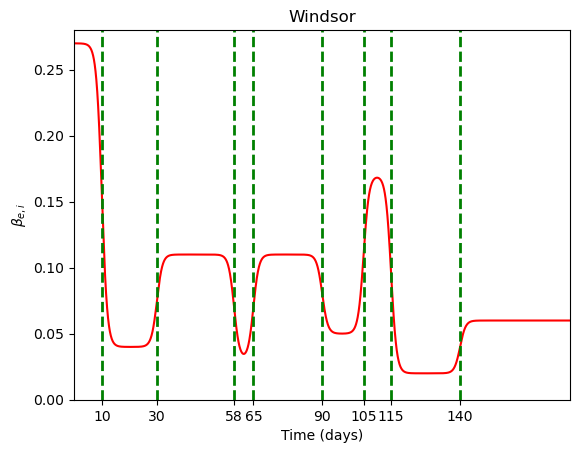

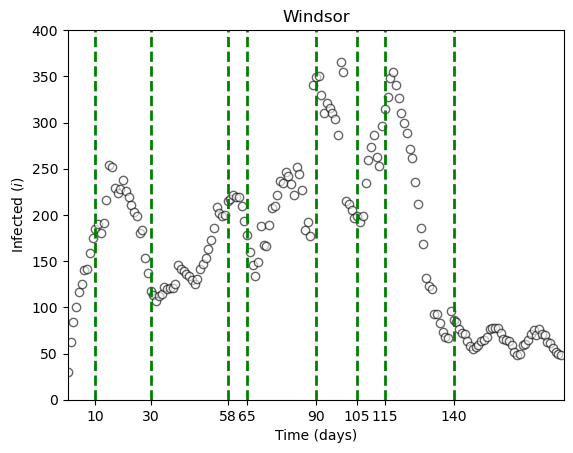

In [17]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

Ndays = 274
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))
I0 = Data[32,0]/population_by_phu[32,1]
D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]
beta = 0.165
gamma = 1/12

## beta = 0.833 gives R0=1


a0 =   0.27

a1 =  -0.23
t1 =  10

a2 =   0.07
t2 =  30

a3 =  -0.08
t3 = 58

a4 =  0.08
t4 = 65

a5 =  -0.06
t5 = 90

a6 =  0.12
t6 = 105

a7 =  -0.15
t7 = 115

a8 =  0.04
t8 = 140

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist))) + a6/(1 + np.exp((t6-tlist))) + a7/(1 + np.exp((t7-tlist))) + a8/(1 + np.exp((t8-tlist)))
beta_e = beta_i



for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])


fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
# plt.grid(True)
# ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.ylim([0,0.28])
x_positions = [10,30,58,65,90,105,115,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--',linewidth=2)  # Adjust ymin and ymax as needed

plt.xticks(x_positions)
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.xlim([0,180])
plt.title("Windsor")
plt.savefig('./figs/beta_windsor.pdf',  bbox_inches='tight')



plt.figure(2)
# plt.plot(tlist,Ytrue[2,:] * population_by_phu[32,1],'k.', linewidth=3, label=r'Generating model')
plt.scatter(tdata[:180],Data[32,:180],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')

plt.ylim([0,400])
x_positions = [10,30,58,65,90,105,115,140]
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--', linewidth=2)  # Adjust ymin and ymax as needed


# plt.grid(True)
plt.xticks(x_positions)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,180])
plt.title("Windsor")
# plt.savefig('./figs/manual_tuned_phu_windsor.pdf',  bbox_inches='tight')
plt.savefig('./figs/Data_phu_windsor.pdf',  bbox_inches='tight')



In [3]:
[t_brandon,S,E,I,R,D,b] = np.loadtxt('./../../data/brandon_synthetic_truth_case2.dat')

sythdata = np.loadtxt('./../../data/brandon_synthetic_data_case2.dat')




Text(0.5, 1.0, 'Toronto')

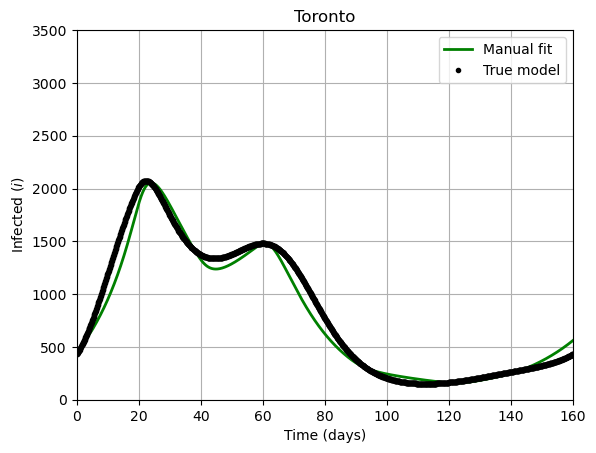

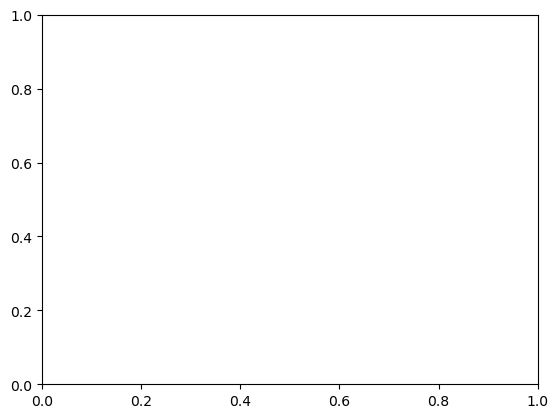

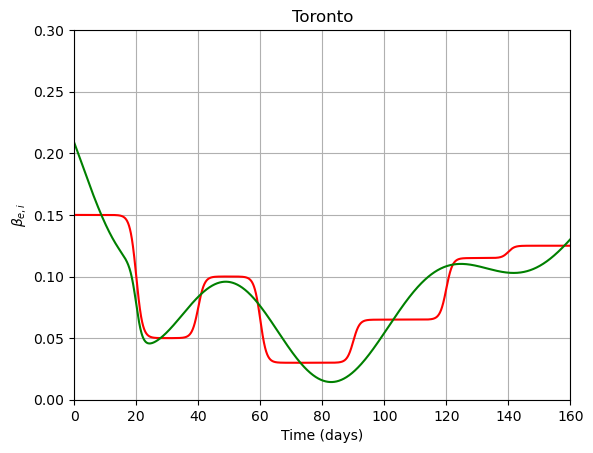

In [7]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
# i_data = i_data[-90:]
# d_data = d_data[-90:]

tdata = np.arange(0,365)


Ndays = 200
sampFac = 24 # sample every sampFac time step
dt = 1/24 # timestep
tgrd = 24*Ndays # time integration grid
tlist = np.linspace(0,Ndays,tgrd) # Define time axis

gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750



Ytrue = np.zeros((5,tgrd))

#### CHANGE HERE ACCORDING TO PHU NUMBER ####
I0 = Data[29,0]/population_by_phu[29,1]
########################################## ####

D0 = 0
R0 = 0
S0 = 1 - 2*I0 - R0 - D0

Ytrue[:,0] = [S0,I0,I0,R0,D0]

## beta = 0.833 gives R0=1

a0 =   0.15
a1 =  -0.1
t1 =  20
a2 =   0.05
t2 =  40
a3 =   -0.07
t3 = 60
a4 =  0.035
t4 = 90
a5 =  0.05
t5 = 120
a6 = 0.01
t6 = 140
a7 =  0.0
t7 = 190
a8 =  0.0
t8 = 230

beta_i = a0 + a1/(1 + np.exp((t1-tlist))) +  a2/(1 + np.exp((t2-tlist))) + a3/(1 + np.exp((t3-tlist))) + a4/(1 + np.exp((t4-tlist))) + a5/(1 + np.exp((t5-tlist)))  + a6/(1 + np.exp((t6-tlist))) + a7/(1 + np.exp((t7-tlist))) + a8/(1 + np.exp((t8-tlist)))
beta_e = beta_i

for kk in range(1,tgrd):
  Ytrue[0,kk] = Ytrue[0,kk-1] + dt*(-beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] - beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1])
  Ytrue[1,kk] = Ytrue[1,kk-1] + dt*(beta_e[kk-1]*Ytrue[0,kk-1]*Ytrue[1,kk-1] + beta_i[kk-1]*Ytrue[0,kk-1]*Ytrue[2,kk-1] - (gamma_i + gamma_e)*Ytrue[1,kk-1])
  Ytrue[2,kk] = Ytrue[2,kk-1] + dt*(gamma_i*Ytrue[1,kk-1] - (gamma_r + gamma_d)*Ytrue[2,kk-1])
  Ytrue[3,kk] = Ytrue[3,kk-1] + dt*(gamma_e*Ytrue[1,kk-1] + gamma_r*Ytrue[2,kk-1])
  Ytrue[4,kk] = Ytrue[4,kk-1] + dt*(gamma_d*Ytrue[2,kk-1])



#### CHANGE HERE ACCORDING TO PHU NUMBER ####
########################################## ####

plt.figure(2)
plt.plot(tlist,Ytrue[2,:]*population_by_phu[29,1],'g', linewidth=2, label=r'Manual fit')
# plt.scatter(tdata[:180],Data[29,:180],color='w',edgecolors='k',zorder=1,alpha=1,label='Data')
plt.plot(t_brandon,I,'k.', linewidth=2, label=r'True model')
# plt.scatter(tdata[:161],sythdata,color='w',edgecolors='k',zorder=1,alpha=0.1,label='Data')

plt.legend()
plt.ylim([0,3500])
# x_positions = [20,35,60,80,140]
# ymin, ymax = plt.gca().get_ylim()
# plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--', linewidth=2)  # Adjust ymin and ymax as needed

plt.grid(True)
plt.xlabel('Time (days)')
plt.ylabel(r'Infected ($i$)')
plt.xlim([0,160])
plt.title("Toronto")
# plt.savefig('./figs/manual_tuned_phu_toronto.pdf',  bbox_inches='tight')
# plt.ylim([0,0.0005])






fig, ax = plt.subplots()
plt.figure(1)
plt.plot(tlist,beta_i,'r-', label=r'Beta Parameter')
plt.plot(t_brandon,b,'g-', label=r'True Beta')
plt.grid(True)
# ax.legend(loc='center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# plt.ylim([0,0.145])
# x_positions = [20,35,60,80,140]
# ymin, ymax = plt.gca().get_ylim()
# plt.vlines(x_positions, ymin=ymin, ymax=ymax, colors='g', linestyles='--',linewidth=2)  # Adjust ymin and ymax as needed

plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{e,i}$')
plt.ylim([0,0.3])
plt.xlim([0,160])
plt.title("Toronto")
# plt.savefig('./figs/beta_toronto.pdf',  bbox_inches='tight')
# plt.ylim([0,0.25])
